## Evaluation

In [109]:
import torch
import numpy as np
import random
from models.architectures import srgan, srflow
import PIL
import os
import torchvision
from torchvision import transforms
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import torch

# Set a seed for reproducibility
np.random.seed(42)

# Dataset loading
from data import dataloading
from data.era5_temp_dataset import InverseMinMaxScaler

from os.path import exists, join
import matplotlib.pyplot as plt
from matplotlib import transforms
import timeit
import pdb
import argparse
import seaborn as sns

from utils.metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
print('GPUs avail:', torch.cuda.device_count())

# Parse Settings
parser = argparse.ArgumentParser()

# train configs
parser.add_argument("--model", type=str, default="srflow",
                    help="Model you want to train.")
parser.add_argument("--modeltype", type=str, default="srflow",
                    help="Specify modeltype you would like to train [srflow, cdiff, srgan].")
parser.add_argument("--model_path", type=str, default="runs/",
                    help="Directory where models are saved.")
parser.add_argument("--modelname", type=str, default=None,
                    help="Sepcify modelname to be tested.")
parser.add_argument("--epochs", type=int, default=10000,
                    help="number of epochs")
parser.add_argument("--max_steps", type=int, default=2000000,
                    help="For training on a large dataset.")
parser.add_argument("--log_interval", type=int, default=100,
                    help="Interval in which results should be logged.")

# runtime configs
parser.add_argument("--visual", action="store_true",
                    help="Visualizing the samples at test time.")
parser.add_argument("--noscaletest", action="store_true",
                    help="Disable scale in coupling layers only at test time.")
parser.add_argument("--noscale", action="store_true",
                    help="Disable scale in coupling layers.")
parser.add_argument("--testmode", action="store_true",
                    help="Model run on test set.")
parser.add_argument("--train", action="store_true",
                    help="If model should be trained.")
parser.add_argument("--resume_training", action="store_true",
                    help="If training should be resumed.")
parser.add_argument("--constraint", type=str, default='scaddDS',
                    help="Physical Constraint to be applied during training.")                   

# hyperparameters
parser.add_argument("--nbits", type=int, default=8,
                    help="Images converted to n-bit representations.")
parser.add_argument("--s", type=int, default=16, help="Upscaling factor.")
parser.add_argument("--bsz", type=int, default=16, help="batch size")
parser.add_argument("--lr", type=float, default=0.0002, help="learning rate")
parser.add_argument("--filter_size", type=int, default=512, help="filter size NN in Affine Coupling Layer")
parser.add_argument("--L", type=int, default=3, help="# of levels")
parser.add_argument("--K", type=int, default=2,
                    help="# of flow steps, i.e. model depth")
parser.add_argument("--nb", type=int, default=16,
                    help="# of residual-in-residual blocks LR network.")
parser.add_argument("--condch", type=int, default=128//8,
                    help="# of residual-in-residual blocks in LR network.")

# data
parser.add_argument("--datadir", type=str, default="/home/christina/Documents/clim-var-ds-cnf-own/data/",
                    help="Dataset to train the model on.")
parser.add_argument("--trainset", type=str, default="era5-TCW", help='[era5-TCW, era5-T2M, noresm]')
parser.add_argument("--testset", type=str, default="era5-TCW", help="Specify test dataset")

args = parser.parse_args('')
config = vars(args)

GPUs avail: 1


In [111]:
if torch.cuda.is_available():
    args.device = torch.device("cuda")
    args.num_gpus = torch.cuda.device_count()
    args.parallel = False

else:
    args.device = "cpu"

In [112]:
# use min-max due to non-gaussian distribution of data and outlier handling
def min_max_scaler(x, min_val=0, max_val=124):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    scaled_x = (x - min_val) / (max_val - min_val)
    return scaled_x, min_val, max_val

def inv_min_max_scaler(scaled_x, min_val=0, max_val=124):
    x = scaled_x * (max_val - min_val) + min_val
    return x

In [113]:
import os
import torch

def load_model(exp_dir, model, mpath):
    """
    Load a model from the specified directory and checkpoint file.
    
    Parameters:
    exp_dir (str): The experiment directory path.
    model (torch.nn.Module): The model instance to load the state dictionary into.
    mpath (str): The path to the model checkpoint file.
    
    Returns:
    torch.nn.Module: The loaded model with the state dictionary.
    
    Raises:
    FileNotFoundError: If the model file does not exist at the specified path.
    """
    try:
        # Check if the file exists
        if not os.path.exists(mpath):
            raise FileNotFoundError(f"Model file not found at {mpath}")
        
        # Load the checkpoint
        ckpt = torch.load(mpath)
        
        # Load the state dictionary into the model
        model.load_state_dict(ckpt['model_state_dict'])
        
        print("Model loaded successfully.")
        return model

    except FileNotFoundError as e:
        print(e)
        return None

### Metric Evaluation
Evaluations: 
- CNF unconstrained vs. constrained
- CNF vs. GAN vs. CDiff
- Residual Error Plots for ???
- Metrics for 2x,4x,8x,16x with and without constraints

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.gridspec import GridSpec
import sys
import torchvision.utils as vutils

sys.path.append("../../")
from utils import metrics

def save_snapshot(tensor, path):
    """Save tensor as image in Viridis color scheme."""
    plt.figure()
    plt.imshow(tensor[0,...].cpu().numpy().squeeze(), cmap='viridis')
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()


def save_grid_images(tensor_batch, save_path, nrow=3, title=None):
    """Create and save a grid of images."""
    grid_img = vutils.make_grid(tensor_batch[0:9], nrow=nrow, normalize=True, scale_each=True)
    np_grid = grid_img.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid[:, :, 0], cmap='viridis')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    

def plot_absolute_error_with_grid(y_unorm, predictions, save_path_grid, save_path_error_bar):
    """Plot and save a 3x3 grid of normalized absolute error images and a separate error bar plot."""
    
    # Calculate absolute errors and their normalization
    abs_error = torch.abs(predictions - y_unorm).cpu().numpy()
    abs_error_min = np.min(abs_error)
    abs_error_max = np.max(abs_error)
    abs_error_normalized = (abs_error - abs_error_min) / (abs_error_max - abs_error_min)
    
    # Remove singleton dimensions if present
    abs_error_normalized = abs_error_normalized.squeeze()  # Remove single-dimensional entries from shape
    
    # Extract the first 9 normalized absolute error images
    num_images = min(abs_error_normalized.shape[0], 9)
    error_images = [torch.tensor(abs_error_normalized[i]).unsqueeze(0) for i in range(num_images)]
    
    # Create a grid of images using PyTorch
    grid = vutils.make_grid(torch.stack(error_images), nrow=3, padding=0)
    
    # Convert the grid to a NumPy array
    np_grid = grid.cpu().numpy().transpose((1, 2, 0))
    
    # Create a figure for the grid of error images
    plt.figure(figsize=(15, 15))
    # pdb.set_trace()
    plt.imshow(np_grid[...,0], cmap='inferno', vmin=0, vmax=1)  # Set vmin and vmax for consistent color mapping
    plt.axis('off')  # Turn off the axis
    
    # Add a color bar
    cbar = plt.colorbar()
    cbar.set_label('Normalized Absolute Error')
    
    # Save the grid figure
    plt.savefig(save_path_grid, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Compute and plot the error bar chart
    means = [np.mean(abs_error_normalized[i]) for i in range(num_images)]
    stds = [np.std(abs_error_normalized[i]) for i in range(num_images)]
    
    # Create a separate figure for the error bar plot
    plt.figure(figsize=(10, 10))
    plt.errorbar(range(num_images), means, yerr=stds, fmt='o', capsize=5, capthick=2, ecolor='red', color='blue')
    plt.xlabel('Image Index')
    plt.ylabel('Normalized Absolute Error')
    plt.title('Error Bar Plot')
    
    # Save the error bar plot figure
    plt.savefig(save_path_error_bar, bbox_inches='tight')
    plt.close()
    
def metric_eval_flow(dataloader, model, exp_name, args):
    metric_dict = {
        'rmse0': [], 'mse0': [], 'mae0': [],
        'rmse05': [], 'mse05': [], 'mae05': [],
        'rmse08': [], 'mse08': [], 'mae08': [],
        'rmse1': [], 'mse1': [], 'mae1': [],
        'crps0': [], 'crps05': [], 'crps08': [], 'crps1': [],
    }

    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(args.device)
            x = item[1].to(args.device)
            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            z, _ = model.forward(x_hr=y, xlr=x)

            # Predictions at different eps values
            mu0, _, _ = model(xlr=x, reverse=True, eps=0)
            mu05, _, _ = model(xlr=x, reverse=True, eps=0.5)
            mu08, _, _ = model(xlr=x, reverse=True, eps=0.8)
            mu1, _, _ = model(xlr=x, reverse=True, eps=1.0)

            # Compute and store metrics
            mse_values = {
                'mse0': metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy(),
                'mse05': metrics.MSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy(),
                'mse08': metrics.MSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy(),
                'mse1': metrics.MSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy(),
            }
            mae_values = {
                'mae0': metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy(),
                'mae05': metrics.MAE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy(),
                'mae08': metrics.MAE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy(),
                'mae1': metrics.MAE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy(),
            }
            rmse_values = {
                'rmse0': metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy(),
                'rmse05': metrics.RMSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy(),
                'rmse08': metrics.RMSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy(),
                'rmse1': metrics.RMSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy(),
            }

            # Calculate CRPS for ensemble
            crps_values = {
                'crps0': crps_ensemble(y_unorm, inv_min_max_scaler(mu0)),
                'crps05': crps_ensemble(y_unorm, inv_min_max_scaler(mu05)),
                'crps08': crps_ensemble(y_unorm, inv_min_max_scaler(mu08)),
                'crps1': crps_ensemble(y_unorm, inv_min_max_scaler(mu1)),
            }

            # Append metrics
            metric_dict['mse0'].append(mse_values['mse0'])
            metric_dict['mse05'].append(mse_values['mse05'])
            metric_dict['mse08'].append(mse_values['mse08'])
            metric_dict['mse1'].append(mse_values['mse1'])
            metric_dict['mae0'].append(mae_values['mae0'])
            metric_dict['mae05'].append(mae_values['mae05'])
            metric_dict['mae08'].append(mae_values['mae08'])
            metric_dict['mae1'].append(mae_values['mae1'])
            metric_dict['rmse0'].append(rmse_values['rmse0'])
            metric_dict['rmse05'].append(rmse_values['rmse05'])
            metric_dict['rmse08'].append(rmse_values['rmse08'])
            metric_dict['rmse1'].append(rmse_values['rmse1'])
            metric_dict['crps0'].append(crps_values['crps0'])
            metric_dict['crps05'].append(crps_values['crps05'])
            metric_dict['crps08'].append(crps_values['crps08'])
            metric_dict['crps1'].append(crps_values['crps1'])

            # Save grid of images (for simplicity, only the first batch)
            if batch_idx == 0:
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(mu05, os.path.join(snapshots_dir, f'prediction_mu05_{batch_idx}.png'))
                save_grid_images(mu08, os.path.join(snapshots_dir, f'prediction_mu08_{batch_idx}.png'))
                save_grid_images(mu1, os.path.join(snapshots_dir, f'prediction_mu1_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))

            print(f'Current RMSE - mu0: {rmse_values["rmse0"]}, mu05: {rmse_values["rmse05"]}, mu08: {rmse_values["rmse08"]}, mu1: {rmse_values["rmse1"]}')
            print(f'Current MAE - mu0: {mae_values["mae0"]}, mu05: {mae_values["mae05"]}, mu08: {mae_values["mae08"]}, mu1: {mae_values["mae1"]}')

            # if batch_idx ==1:
            #     break
     
        # Plot absolute errors
        predictions = inv_min_max_scaler(mu08)
        plot_absolute_error_with_grid(y_unorm, predictions, os.path.join(results_dir, 'absolute_error_mu08.png'), os.path.join(results_dir, 'error_bars_mu08.png'))
        
        # Create mean metrics
        mean_dict = {key: float(np.mean(value)) for key, value in metric_dict.items() if len(value) > 0}

        # Save metrics to file
        with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
            json.dump(mean_dict, f, indent=4)

        print(mean_dict)

    return mean_dict

# Experiments: Comparing across upsampling factors - ERA5 TWC Dataset

In [86]:
# load model
print('Num of avail GPUs:', torch.cuda.device_count())

Num of avail GPUs: 1


In [87]:
import gc
gc.collect()

44

### Conditional Flow Model

In [88]:
args.s = 2
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf2x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 2, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/model_checkpoints/model_epoch_8_step_21500.tar'

# load the model
cnf2x = load_model(exp_dir, cnf2x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf2x, exp_dir, args)

Loading NORESM ...
Model loaded successfully.


ValueError: Expected value argument (Tensor of shape (16, 2, 32, 32)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([16, 2, 32, 32]), scale: torch.Size([16, 2, 32, 32])), but found invalid values:
tensor([[[[ -2.8531,  -1.8565,  -4.9474,  ...,  -5.1441,  -3.7895,  -2.6504],
          [ -1.4666,  -9.0082,  -5.0537,  ...,  -2.6090,  -2.0521,  -7.4684],
          [ -5.5011,  -2.7631, -12.6036,  ...,  -9.0518,  -7.5882,  -5.5820],
          ...,
          [  2.3199,  -8.4555,   3.1608,  ...,  -7.2064,  -0.1835,  -5.6098],
          [ -4.3608,   7.4318,  -8.3412,  ..., -23.8870,  -1.3626, -11.9411],
          [ -5.5669,  -2.8719,  -3.6274,  ...,  -6.4111,  -6.7195,  -0.7489]],

         [[  2.6130,   4.3976,   4.8835,  ...,   4.2637,   4.4178,   5.6809],
          [  5.8052,   7.4479,   4.3797,  ...,  -5.0096,  -3.4491,   7.5848],
          [  0.7716,  10.0519,  -0.8991,  ...,   2.3800,   0.3692,   6.4086],
          ...,
          [ -4.4254,  12.7513,  -2.8305,  ...,   2.8038,   2.3149,   3.8336],
          [  6.2438,   2.2158,   9.6960,  ...,   1.5134,   9.5779,   5.9655],
          [  0.4840,   3.2887,   3.3554,  ...,   1.7612,   3.0522,   5.5832]]],


        [[[ -1.7819,  -3.4878,  -4.3767,  ...,  -2.9808,  -5.5558,  -1.5389],
          [ -5.4747,  -6.3514, -14.8130,  ..., -11.7845,  -4.6223,  -3.7994],
          [-11.1032,   2.4840,  -5.3373,  ...,  -8.5913,  -7.1416,  -6.6117],
          ...,
          [ -6.0343, -10.6484, -10.7132,  ...,  -7.0514,  -0.9711,  -2.3354],
          [ -5.0827, -14.8527,  -3.3498,  ...,  -6.2528,  -5.0314,  -0.7319],
          [ -2.1748,  -0.5565,  -6.4208,  ...,  -4.6979,  -2.4667,  -0.2956]],

         [[  1.0722,   1.2292,   3.5777,  ...,   5.8074,   1.2225,   3.1777],
          [  5.8520,  13.9785,   3.5354,  ...,  15.9058,   3.0071,   6.2426],
          [  4.0273,   0.2579,  -1.1159,  ...,  -0.5796,   6.9450,   3.2687],
          ...,
          [  0.6103, -12.0217,  15.9887,  ...,  10.4693,  -0.7695,   6.4019],
          [  2.5567,   7.0939,   7.3084,  ...,  13.2253,   3.7833,   8.1492],
          [  2.6746,   8.3703,   9.8199,  ...,   9.3481,   2.6761,   3.0621]]],


        [[[ -4.4502,  -2.2910,  -2.9158,  ...,   0.0710,  -0.4350,  -0.0686],
          [ -4.1510,  -6.5786,  -7.4663,  ..., -10.6148,  -8.0242,   0.1664],
          [ -2.1209,  -9.8215,  -0.4756,  ...,  -2.6369,  -8.7630,  -6.7317],
          ...,
          [ -7.5666,   9.3914,  -3.2642,  ...,  -6.4413, -12.6417,   1.8100],
          [ -3.7987,  -7.6255,   4.6338,  ...,  -2.4590, -11.0432,  -8.1334],
          [ -0.0996,  -2.6951,  -1.4699,  ...,  -6.2807,  -0.2689,  -8.5281]],

         [[  1.7167,   4.3234,   0.6255,  ...,   6.9146,   2.7086,   1.4314],
          [ -0.0461,   1.4185,   0.2239,  ...,   8.5057,  -3.2102,   3.8977],
          [  8.2901,   6.1443,  12.7973,  ...,  -0.6933,  -1.7743,   3.0839],
          ...,
          [  1.4196,  -2.5763,  10.4697,  ...,   5.9352,   4.9695,   3.0303],
          [  6.4853,  10.6256,  12.1640,  ...,  -1.8491,   2.1205,   4.2679],
          [  2.5236,   6.7244,   0.4463,  ...,   4.1309,   3.7967,   3.5122]]],


        ...,


        [[[ -1.7376,  -2.9244,  -2.9505,  ...,  -2.4961,  -2.7657,  -2.8559],
          [ -4.9414,  -5.0405,   2.3250,  ...,  -7.1556,   0.6989,  -4.7110],
          [ -4.2085,  -4.2097,   3.3307,  ...,  -2.5674,   3.8135,  -1.8625],
          ...,
          [ -0.2778,  -1.4647,  -5.6854,  ..., -16.6538,  -7.4475,  -1.4178],
          [ -7.8818,   1.1903,  -6.6895,  ...,  -3.8902, -10.4802,  -4.8867],
          [ -4.4302,  -0.9961,  -6.9221,  ...,  -3.4541,   0.9788,  -4.5238]],

         [[  1.6988,   7.0238,  10.4371,  ...,   3.2921,   0.4571,   3.4860],
          [  4.5979,  -1.0557,   5.5274,  ...,  -0.6932,   9.6328,  -2.5700],
          [ -1.3320,   5.0374,  18.3883,  ...,   2.6477,   5.8442,   1.3692],
          ...,
          [ 12.7734,   7.7482,  20.0715,  ...,  13.7685,  12.9700,   9.4674],
          [  7.6521,   7.0565,   9.7643,  ...,  -0.8687,   1.3759,   1.9036],
          [  4.2572,   6.9753,   6.7962,  ...,  10.3341,   4.6011,   1.6121]]],


        [[[  0.2871,   2.2323,  -4.6417,  ...,  -2.9726,  -1.7112,   0.0862],
          [ -3.7416,  -5.2797,  -8.9891,  ...,  -3.4477,   1.1634,  -5.6690],
          [ -5.2510,  -7.0395,   0.4492,  ...,  -6.7980, -14.0847,  -2.2399],
          ...,
          [ -2.3018,   2.5609,  -8.8180,  ...,  -3.1461,   1.8974,  -0.3512],
          [  0.1726,  -7.4978, -10.6811,  ...,   7.2575,  -2.9854,  -8.3222],
          [ -0.3965,  -6.5727,  -5.2260,  ...,  -2.7547,  -6.4097,  -5.3638]],

         [[  2.7031,  -0.4558,   4.5627,  ...,   0.5797,   3.7452,   0.9236],
          [  2.7627,   5.3441,   8.5924,  ...,   3.2339,   5.2178,   1.2055],
          [ -3.8004,   0.8786,   1.0068,  ...,  -1.4231,   9.3872,   5.8020],
          ...,
          [  1.3367,   0.8657,  11.0248,  ...,   4.9894,   5.7275,  12.4592],
          [  4.4861,  10.7220,  16.7079,  ...,   6.6531,   8.1153,   6.5395],
          [  1.4728,   9.1504,   4.2861,  ...,   6.9328,   0.4331,   5.6395]]],


        [[[ -3.0412,  -4.2385,  -1.7096,  ...,  -0.0265,  -1.4211,  -1.8350],
          [ -2.5681,  -3.3759,  -5.8907,  ...,  -0.9067, -11.2278,  -1.1852],
          [ -7.6211,  -4.5425,  -7.8229,  ...,  -3.6171,  -2.5258,   0.6047],
          ...,
          [ -6.9923,   2.6634,  -3.6291,  ...,  -6.5121,  -9.1686,  -1.0681],
          [ -5.3346,   1.4669, -14.3872,  ...,   0.3873,  -2.9598,  -1.0582],
          [ -2.7377,  -6.3064,  -0.9650,  ...,  -7.2684,  -6.3406,  -2.7541]],

         [[  2.1654,   4.1962,   3.8524,  ...,   6.8403,   4.4834,   2.0128],
          [ -3.2488,   3.3131,   2.1501,  ...,  -0.8506,  -1.3401,   4.4985],
          [  7.1274,   4.0683,   2.8054,  ...,   1.6751,  -0.9666,   9.4476],
          ...,
          [  4.5716,   8.7825,   1.6691,  ...,   0.3950,   7.8486,   7.6514],
          [  3.5957,  -2.4685,   7.1247,  ...,   2.6457,   2.4141,   9.2042],
          [  6.8098,  -0.4047,   5.3323,  ...,   5.6844,   6.8341,   4.4494]]]],
       device='cuda:0')

In [1]:
gc.collect()

NameError: name 'gc' is not defined

In [ ]:
args.s = 4
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf4x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/model_checkpoints/model_epoch_10_step_26250.tar'
# Load the model
cnf4x = load_model(exp_dir, cnf4x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf4x, exp_dir, args)

In [ ]:
gc.collect()

In [ ]:
args.s = 8
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf8x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, args.s, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/model_checkpoints/model_epoch_4_step_11500.tar'
# Load the model
cnf8x = load_model(exp_dir, cnf8x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf8x, exp_dir, args)

In [ ]:
gc.collect()

In [ ]:
args.s = 16
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf16x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 16, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/model_checkpoints/model_epoch_5_step_13750.tar'
# Load the model
cnf16x = load_model(exp_dir, cnf16x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf16x, exp_dir, args)

In [ ]:
gc.collect()

### Conditional GAN

In [52]:
import os
import json
import torch
import torchvision.utils as vutils
import sys
sys.path.append("../../")
from utils import metrics

def save_snapshot(tensor, path):
    """Save tensor as image in Viridis color scheme."""
    plt.figure()
    plt.imshow(tensor[0,...].cpu().numpy().squeeze(), cmap='viridis')
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()


def save_grid_images(tensor_batch, save_path, nrow=3, title=None):
    """Create and save a grid of images."""
    grid_img = vutils.make_grid(tensor_batch[0:9], nrow=nrow, normalize=True, scale_each=True)
    np_grid = grid_img.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid[:, :, 0], cmap='viridis')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
def metric_eval_gan(dataloader, model, exp_name, args):
    metric_dict = {
        'rmse0': [], 'mse0': [], 'mae0': [],
        'rmse05': [], 'mse05': [], 'mae05': [],
        'rmse08': [], 'mse08': [], 'mae08': [],
        'rmse1': [], 'mse1': [], 'mae1': [],
        'crps0': [], 'crps05': [],'crps08': [],'crps1': [],
    }

    # Create directories
    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            # Evaluate for different temperatures
            mu0 = model(x, eps=0)
            mu05 = model(x, eps=0.5)
            mu08 = model(x, eps=0.8)
            mu1 = model(x, eps=1.0)

            # Compute and store MSE for each temperature
            mse0 = metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mse05 = metrics.MSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mse08 = metrics.MSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mse1 = metrics.MSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()
            
            metric_dict['mse0'].append(mse0)
            metric_dict['mse05'].append(mse05)
            metric_dict['mse08'].append(mse08)
            metric_dict['mse1'].append(mse1)

            # Compute and store MAE for each temperature
            mae0 = metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mae05 = metrics.MAE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mae08 = metrics.MAE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mae1 = metrics.MAE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['mae0'].append(mae0)
            metric_dict['mae05'].append(mae05)
            metric_dict['mae08'].append(mae08)
            metric_dict['mae1'].append(mae1)

            # Compute and store RMSE for each temperature
            rmse0 = metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            rmse05 = metrics.RMSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            rmse08 = metrics.RMSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            rmse1 = metrics.RMSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['rmse0'].append(rmse0)
            metric_dict['rmse05'].append(rmse05)
            metric_dict['rmse08'].append(rmse08)
            metric_dict['rmse1'].append(rmse1)

             # Calculate CRPS for ensemble
            metric_dict['crps0'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu0)))
            metric_dict['crps05'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu05)))
            metric_dict['crps08'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu08)))
            metric_dict['crps1'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu1)))
            
            # Save grid of images for visualization (adjust as needed)
            if batch_idx == 0:  # Save only for the first batch for simplicity
                # Save snapshots
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(mu05, os.path.join(snapshots_dir, f'prediction_mu05_{batch_idx}.png'))
                save_grid_images(mu08, os.path.join(snapshots_dir, f'prediction_mu08_{batch_idx}.png'))
                save_grid_images(mu1, os.path.join(snapshots_dir, f'prediction_mu1_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))
                
            print(f'Current RMSE - mu0: {rmse0}, mu05: {rmse05}, mu08: {rmse08}, mu1: {rmse1}')
            print(f'Current MAE - mu0: {mae0}, mu05: {mae05}, mu08: {mae08}, mu1: {mae1}')
            # print(f'Current CRPS - mu0:{crps0}, mu05: {crps05}, mu08: {crps08}, m1: {crps1}')

            if batch_idx == 2:
                break
    
    # Plot absolute errors
    predictions = inv_min_max_scaler(mu08)
    plot_absolute_error_with_grid(y_unorm, predictions, os.path.join(results_dir, 'absolute_error_mu08.png'), os.path.join(results_dir, 'error_bars_mu08.png'))
       
    # Create a string representation of the metric_dict
    mean_dict = {}
    for key, value in metric_dict.items():
        if len(value) > 0:
            mean_dict[key] = np.mean(value)   
            
    metric_str = "\n".join([f"{key}: {value}" for key, value in mean_dict.items()])

    # Save metric_dict to a text file
    with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
        json.dump(metric_str, f, indent=4)
        
    print(mean_dict)
    return mean_dict

In [91]:
args.s = 2
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan2x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/model_checkpoints/generator_epoch_13_step_34000.tar'
# Load the model
srgan2x = load_model(exp_dir, srgan2x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan2x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 0.44392889738082886, mu05: 0.4507226347923279, mu08: 0.462285578250885, mu1: 0.4773579239845276
Current MAE - mu0: 0.23985344171524048, mu05: 0.24803069233894348, mu08: 0.2599413990974426, mu1: 0.2741978168487549
Current RMSE - mu0: 0.5369295477867126, mu05: 0.5400278568267822, mu08: 0.5484990477561951, mu1: 0.5570924282073975
Current MAE - mu0: 0.29851919412612915, mu05: 0.30288976430892944, mu08: 0.3110339343547821, mu1: 0.3204658627510071
Current RMSE - mu0: 0.48289233446121216, mu05: 0.4892057776451111, mu08: 0.5027265548706055, mu1: 0.5172818303108215
Current MAE - mu0: 0.25939661264419556, mu05: 0.26741722226142883, mu08: 0.2800706624984741, mu1: 0.2948504686355591
{'rmse0': 0.48791695, 'mse0': 0.32238808, 'mae0': 0.26592308, 'rmse05': 0.49331877, 'mse05': 0.3259026, 'mae05': 0.27277923, 'rmse08': 0.5045037, 'mse08': 0.33466363, 'mae08': 0.283682, 'rmse1': 0.51724404, 'mse1': 0.34356046, 'mae1': 0.2965047, 'crps0

{'rmse0': 0.48791695,
 'mse0': 0.32238808,
 'mae0': 0.26592308,
 'rmse05': 0.49331877,
 'mse05': 0.3259026,
 'mae05': 0.27277923,
 'rmse08': 0.5045037,
 'mse08': 0.33466363,
 'mae08': 0.283682,
 'rmse1': 0.51724404,
 'mse1': 0.34356046,
 'mae1': 0.2965047,
 'crps0': 0.14127511,
 'crps05': 0.14377257,
 'crps08': 0.14578807,
 'crps1': 0.14809906}

In [92]:
args.s = 4
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan4x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/model_checkpoints/generator_epoch_11_step_28250.tar'
# Load the model
srgan4x = load_model(exp_dir, srgan4x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan4x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 0.7338263988494873, mu05: 0.7398586273193359, mu08: 0.7587447166442871, mu1: 0.777892529964447
Current MAE - mu0: 0.446969211101532, mu05: 0.4507952630519867, mu08: 0.4637916684150696, mu1: 0.4810130298137665
Current RMSE - mu0: 0.9192687273025513, mu05: 0.924476146697998, mu08: 0.9367569088935852, mu1: 0.9539824724197388
Current MAE - mu0: 0.5594886541366577, mu05: 0.5634498596191406, mu08: 0.5734217166900635, mu1: 0.5872389078140259
Current RMSE - mu0: 0.7814721465110779, mu05: 0.7875902056694031, mu08: 0.8047618269920349, mu1: 0.8229349851608276
Current MAE - mu0: 0.47751161456108093, mu05: 0.4818885922431946, mu08: 0.49502676725387573, mu1: 0.5092750787734985
{'rmse0': 0.8115224, 'mse0': 0.86444336, 'mae0': 0.49465647, 'rmse05': 0.81730837, 'mse05': 0.87228394, 'mae05': 0.49871126, 'rmse08': 0.8334212, 'mse08': 0.89187956, 'mae08': 0.5107467, 'rmse1': 0.8516033, 'mse1': 0.9152675, 'mae1': 0.52584237, 'crps0': 0.245

{'rmse0': 0.8115224,
 'mse0': 0.86444336,
 'mae0': 0.49465647,
 'rmse05': 0.81730837,
 'mse05': 0.87228394,
 'mae05': 0.49871126,
 'rmse08': 0.8334212,
 'mse08': 0.89187956,
 'mae08': 0.5107467,
 'rmse1': 0.8516033,
 'mse1': 0.9152675,
 'mae1': 0.52584237,
 'crps0': 0.24559386,
 'crps05': 0.25030568,
 'crps08': 0.25956845,
 'crps1': 0.27146026}

In [93]:
args.s = 8
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan8x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/model_checkpoints/generator_epoch_11_step_30000.tar'
# Load the model
srgan8x = load_model(exp_dir, srgan8x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan8x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 1.410731315612793, mu05: 1.4458110332489014, mu08: 1.5120079517364502, mu1: 1.5991230010986328
Current MAE - mu0: 0.913824200630188, mu05: 0.9370038509368896, mu08: 0.981981635093689, mu1: 1.0293774604797363
Current RMSE - mu0: 1.7806434631347656, mu05: 1.7995271682739258, mu08: 1.8555786609649658, mu1: 1.887093424797058
Current MAE - mu0: 1.168839454650879, mu05: 1.1808850765228271, mu08: 1.213746190071106, mu1: 1.2455253601074219
Current RMSE - mu0: 1.4909443855285645, mu05: 1.528975248336792, mu08: 1.5871379375457764, mu1: 1.6607849597930908
Current MAE - mu0: 0.9728440642356873, mu05: 0.99462890625, mu08: 1.034603476524353, mu1: 1.0830531120300293
{'rmse0': 1.560773, 'mse0': 2.956913, 'mae0': 1.0185026, 'rmse05': 1.5914378, 'mse05': 3.0359204, 'mae05': 1.037506, 'rmse08': 1.6515747, 'mse08': 3.1983001, 'mae08': 1.0767771, 'rmse1': 1.7156671, 'mse1': 3.3827927, 'mae1': 1.1193186, 'crps0': 0.49616468, 'crps05': 0.505

{'rmse0': 1.560773,
 'mse0': 2.956913,
 'mae0': 1.0185026,
 'rmse05': 1.5914378,
 'mse05': 3.0359204,
 'mae05': 1.037506,
 'rmse08': 1.6515747,
 'mse08': 3.1983001,
 'mae08': 1.0767771,
 'rmse1': 1.7156671,
 'mse1': 3.3827927,
 'mae1': 1.1193186,
 'crps0': 0.49616468,
 'crps05': 0.505349,
 'crps08': 0.5288534,
 'crps1': 0.5538419}

In [94]:
args.s = 16
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan16x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)

exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/model_checkpoints/generator_epoch_13_step_34250.tar'

# Load the model
srgan16x = load_model(exp_dir, srgan16x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan16x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 2.1359100341796875, mu05: 2.1393063068389893, mu08: 2.1428451538085938, mu1: 2.1576788425445557
Current MAE - mu0: 1.4943206310272217, mu05: 1.4971261024475098, mu08: 1.4999451637268066, mu1: 1.5148606300354004
Current RMSE - mu0: 2.81673526763916, mu05: 2.8172407150268555, mu08: 2.8217549324035645, mu1: 2.823082447052002
Current MAE - mu0: 1.9477269649505615, mu05: 1.9482349157333374, mu08: 1.9527755975723267, mu1: 1.9545542001724243
Current RMSE - mu0: 2.197573661804199, mu05: 2.2010083198547363, mu08: 2.212495803833008, mu1: 2.2246718406677246
Current MAE - mu0: 1.5478706359863281, mu05: 1.5514025688171387, mu08: 1.5587632656097412, mu1: 1.5706472396850586
{'rmse0': 2.3834064, 'mse0': 6.884238, 'mae0': 1.6633061, 'rmse05': 2.3858516, 'mse05': 6.891504, 'mae05': 1.6655879, 'rmse08': 2.3923652, 'mse08': 6.9139276, 'mae08': 1.6704947, 'rmse1': 2.4018111, 'mse1': 6.9380417, 'mae1': 1.6800207, 'crps0': 0.8809101, 'crps05

{'rmse0': 2.3834064,
 'mse0': 6.884238,
 'mae0': 1.6633061,
 'rmse05': 2.3858516,
 'mse05': 6.891504,
 'mae05': 1.6655879,
 'rmse08': 2.3923652,
 'mse08': 6.9139276,
 'mae08': 1.6704947,
 'rmse1': 2.4018111,
 'mse1': 6.9380417,
 'mae1': 1.6800207,
 'crps0': 0.8809101,
 'crps05': 0.87483007,
 'crps08': 0.8740557,
 'crps1': 0.86938554}

# Experiments: Comparing across upsampling factors - NORESM Dataset


In [129]:
import gc
gc.collect()

22

In [130]:
# use min-max due to non-gaussian distribution of data and outlier handling
def min_max_scaler(x, min_val=209.43, max_val=317.14):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    scaled_x = (x - min_val) / (max_val - min_val)
    return scaled_x, min_val, max_val

def inv_min_max_scaler(scaled_x, min_val=209.43, max_val=317.14):
    x = scaled_x * (max_val - min_val) + min_val
    return x

### Conditional Flow Model

#### 2x

In [131]:
args.s = 2
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf2x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 2, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_noresm_None__2024_08_19_09_10_40_2x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_noresm_None__2024_08_19_09_10_40_2x/model_epoch_6_step_10500.tar'

# load the model
cnf2x = load_model(exp_dir, cnf2x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf2x, exp_dir, args)

Loading NORESM ...
Model loaded successfully.
Current RMSE - mu0: 0.2095482349395752, mu05: 0.2900233268737793, mu08: 0.38767367601394653, mu1: 0.45791861414909363
Current MAE - mu0: 0.13159510493278503, mu05: 0.2002725899219513, mu08: 0.2717641592025757, mu1: 0.3216250538825989
Current RMSE - mu0: 0.24701203405857086, mu05: 0.32003170251846313, mu08: 0.4159420132637024, mu1: 0.4850046634674072
Current MAE - mu0: 0.1546044647693634, mu05: 0.21751341223716736, mu08: 0.2900071144104004, mu1: 0.34164494276046753
Current RMSE - mu0: 0.20769724249839783, mu05: 0.2918635606765747, mu08: 0.38195353746414185, mu1: 0.4540051817893982
Current MAE - mu0: 0.13011255860328674, mu05: 0.20029029250144958, mu08: 0.27007824182510376, mu1: 0.32142117619514465
Current RMSE - mu0: 0.2087765634059906, mu05: 0.29077938199043274, mu08: 0.3788143992424011, mu1: 0.4537190794944763
Current MAE - mu0: 0.13128821551799774, mu05: 0.19999253749847412, mu08: 0.2684895098209381, mu1: 0.32135337591171265


KeyboardInterrupt: 

In [132]:
import gc
gc.collect()

9880

#### 4x

In [ ]:
args.s = 4
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf4x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_noresm_None__2024_08_19_09_10_41_4x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_noresm_None__2024_08_19_09_10_41_4x/model_epoch_8_step_12750.tar'

# Load the model
cnf4x = load_model(exp_dir, cnf4x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf4x, exp_dir, args)

Loading NORESM ...
Model loaded successfully.
Current RMSE - mu0: 0.592420756816864, mu05: 0.6901935935020447, mu08: 0.8248536586761475, mu1: 0.9167230129241943
Current MAE - mu0: 0.32880526781082153, mu05: 0.4204549193382263, mu08: 0.5274477601051331, mu1: 0.5995078086853027
Current RMSE - mu0: 0.6800616979598999, mu05: 0.7719674110412598, mu08: 0.8966804146766663, mu1: 0.973859429359436
Current MAE - mu0: 0.37338170409202576, mu05: 0.45862066745758057, mu08: 0.5618923306465149, mu1: 0.631149411201477
Current RMSE - mu0: 0.6193012595176697, mu05: 0.712600588798523, mu08: 0.8351342678070068, mu1: 0.9224973917007446
Current MAE - mu0: 0.3396548628807068, mu05: 0.42946961522102356, mu08: 0.5322223901748657, mu1: 0.6000559329986572
Current RMSE - mu0: 0.5937623977661133, mu05: 0.6955679655075073, mu08: 0.8164425492286682, mu1: 0.9115849137306213
Current MAE - mu0: 0.32964617013931274, mu05: 0.42258793115615845, mu08: 0.5241554975509644, mu1: 0.5962258577346802
Current RMSE - mu0: 0.613979

#### 8x

#### 16x

In [10]:
def plot_std(model):
    """
    For this experiment we visualize the super-resolution space for a single
    low-resolution image and its possible HR target predictions. We visualize
    the standard deviation of these predictions from the mean of the model.
    """
    color = 'plasma'
    savedir_viz = "experiments/{}_{}_{}/snapshots/population_std/".format(exp_name, modelname, args.trainset)
    os.makedirs(savedir_viz, exist_ok=True)
    model.eval()
    cmap = 'viridis' if args.trainset == 'era5-TCW' else 'inferno'
    with torch.no_grad():
        for batch_idx, item in enumerate(test_loader):

            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unnorm = item[3].to(args.device)

            mu0 = model(x)

            samples = []
            n = 20
            sq_diff = torch.zeros_like(mu0)
            for n in range(n):
                mu1 = model(x)
                samples.append(mu0)
                sq_diff += (mu1 - mu0)**2

            # compute population standard deviation
            sigma = torch.sqrt(sq_diff / n)

            # create plot
            plt.figure()
            plt.imshow(sigma[0,...].permute(1,2,0).cpu().numpy(), cmap=color)
            plt.axis('off')
            # plt.show()
            plt.savefig(savedir_viz + '/sigma_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            plt.close()

            plt.figure()
            plt.imshow(mu0[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            plt.axis('off')
            # plt.show()
            plt.savefig(savedir_viz + '/mu0_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            plt.close()

            fig, (ax1, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,6)
            # fig.suptitle('Y, Y_hat, mu, sigma')
            ax1.imshow(y[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax1.set_title('Ground Truth', fontsize=5)
            ax1.axis('off')
            # ax2.imshow(mu0[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            # divider = make_axes_locatable(ax2)
            # cax = divider.append_axes("right", size="5%", pad=0.05)
            # cax.set_axis_off()
            # ax2.set_title('Mean', fontsize=5)
            # ax2.axis('off')
            ax3.imshow(samples[1][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax3)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax3.set_title('Sample 1', fontsize=5)
            ax3.axis('off')
            ax4.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax4)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax4.set_title('Sample 2', fontsize=5)
            ax4.axis('off')
            ax5.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax5)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax5.set_title('Sample 3', fontsize=5)
            ax5.axis('off')
            ax6.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax6)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax6.set_title('Sample 4', fontsize=5)
            ax6.axis('off')
            divider = make_axes_locatable(ax7)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im7 = ax7.imshow(sigma[0,...].permute(1,2,0).cpu().numpy(), cmap='magma')
            cbar = fig.colorbar(im7,cmap='magma', cax=cax)
            cbar.ax.tick_params(labelsize=5)
            ax7.set_title('Std. Dev.', fontsize=5)
            ax7.axis('off')
            plt.tight_layout()
            plt.savefig(savedir_viz + '/std_multiplot_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            # plt.show()
            plt.close()

    return None

In [ ]:
# especially focus on analyzing extreme value predictions

### Scatter Plot (Predicted vs Target)
![image.png](attachment:image.png)

### Cumulative Distribution of  Residual Errors
![image.png](attachment:image.png)

## Evaluate Power Spectrum

In [61]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_power_spectrum(image):
    # Apply FFT
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Compute the power spectrum
    power_spectrum = np.abs(f_transform_shifted) ** 2

    # Use logarithmic scale for visualization
    log_power_spectrum = np.log(1 + power_spectrum)
    
    return log_power_spectrum
    
def compute_radial_profile(power_spectrum):
    # Get the dimensions of the image
    rows, cols = power_spectrum.shape
    center_row, center_col = rows // 2, cols // 2

    # Create a grid of coordinates
    Y, X = np.indices((rows, cols))
    distances = np.sqrt((X - center_col) ** 2 + (Y - center_row) ** 2)

    # Create radial bins
    max_radius = np.max(distances)
    bin_edges = np.arange(0, max_radius + 1)
    radial_sum = np.zeros(bin_edges.size)
    radial_count = np.zeros(bin_edges.size)

    for i in range(rows):
        for j in range(cols):
            radius = int(distances[i, j])
            radial_sum[radius] += power_spectrum[i, j]
            radial_count[radius] += 1

    radial_mean = radial_sum / (radial_count + 1e-10)  # Avoid division by zero
    return radial_mean

def save_radial_profile(radial_profile, file_path):
    """Save the radial profile to a file."""
    np.savetxt(file_path, radial_profile)
    
def process_images(model, dataloader, output_dir, device, args, modeltype):
    model.eval()
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(device)
            x = item[1].to(device)
            
            y_unorm = item[2].to(device)
            x_unorm = item[3].to(device)

            if modeltype == 'srflow':
                # Forward pass
                z, _ = model.forward(x_hr=y, xlr=x)
                mu0, _, _ = model(xlr=x, reverse=True, eps=0)
                mu0_denorm = inv_min_max_scaler(mu0, y_unorm)
                
            elif modeltype == 'srgan':
                mu0 = model(x, eps=0)
                mu0_denorm = inv_min_max_scaler(mu0, y_unorm)            

            # Compute power spectrum of model output
            mu0_np = mu0_denorm.cpu().numpy()
            power_spectrum_model = compute_power_spectrum(mu0_np[0, 0])  # Assuming single-channel image
            radial_profile_model = compute_radial_profile(power_spectrum_model)

            # Compute power spectrum of ground truth
            y_np = y_unorm.cpu().numpy()
            power_spectrum_gt = compute_power_spectrum(y_np[0, 0])  # Assuming single-channel image
            radial_profile_gt = compute_radial_profile(power_spectrum_gt)

            # Save the radial profiles to files
            model_profile_path = os.path.join(output_dir, f'radial_profile_model_{batch_idx}.txt')
            ground_truth_profile_path = os.path.join(output_dir, f'radial_profile_gt_{batch_idx}.txt')
            save_radial_profile(radial_profile_model, model_profile_path)
            save_radial_profile(radial_profile_gt, ground_truth_profile_path)

            # Plot and save the radial profiles
            output_path = os.path.join(output_dir, f'power_spectrum_comparison_{batch_idx}.png')
            plt.figure()
            plt.plot(np.arange(len(radial_profile_model)), radial_profile_model, color='royalblue', label='Model Output')
            plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, color='darkorange', label='Ground Truth')
            plt.xlabel('Spatial Frequency (k)')
            plt.ylabel('Log Power Spectrum')
            plt.title(f'Power Spectrum Comparison - upsampling factor {args.s}x')
            plt.legend()
            plt.grid(True)
            plt.savefig(output_path, bbox_inches='tight')
            plt.close()

            print(f'Processed and saved: {output_path}')

            if batch_idx == 5:
                break


#### SRFlow 2x

In [62]:
args.s = 2
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf2x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 2, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/model_checkpoints/model_epoch_8_step_21500.tar'
# Load the model
cnf2x = load_model(exp_dir, cnf2x, cnf_path).to(args.device)
process_images(cnf2x, test_loader, 'radial_power_spectra/srflow/2x/denorm/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/2x/denorm/power_spectrum_comparison_5.png


#### SRGAN 2x

In [63]:
args.s = 2
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan2x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/model_checkpoints/generator_epoch_13_step_34000.tar'
# Load the model
srgan2x = load_model(exp_dir, srgan2x, gan_path).to(args.device)
process_images(srgan2x, test_loader, 'radial_power_spectra/srgan/2x/denorm/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/denorm/power_spectrum_comparison_5.png


### SRFlow 4x

In [55]:
args.s = 4
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf4x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/model_checkpoints/model_epoch_10_step_26250.tar'
# Load the model
cnf4x = load_model(exp_dir, cnf4x, cnf_path).to(args.device)
process_images(cnf4x, test_loader, 'radial_power_spectra/srflow/4x/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_5.png


### SRGAN 4x

In [64]:
args.s = 4
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan4x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/model_checkpoints/generator_epoch_11_step_28250.tar'
# Load the model
srgan4x = load_model(exp_dir, srgan4x, gan_path).to(args.device)
process_images(srgan4x, test_loader, 'radial_power_spectra/srgan/4x/denorm/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/denorm/power_spectrum_comparison_5.png


### SRFlow 8x

In [65]:
args.s = 8
args.bsz = 64
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf8x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, args.s, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/model_checkpoints/model_epoch_4_step_11500.tar'
# Load the model
cnf8x = load_model(exp_dir, cnf8x, cnf_path).to(args.device)
process_images(cnf8x, test_loader, 'radial_power_spectra/srflow/8x/denorm/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/8x/denorm/power_spectrum_comparison_5.png


### SRGAN 8x

In [66]:
args.s = 8
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan8x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/model_checkpoints/generator_epoch_11_step_30000.tar'
# Load the model
srgan8x = load_model(exp_dir, srgan8x, gan_path).to(args.device)
process_images(srgan8x, test_loader, 'radial_power_spectra/srgan/8x/denorm/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/denorm/power_spectrum_comparison_5.png


### SRFlow 16x

In [67]:
args.s = 16
args.bsz = 64
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf16x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 16, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/model_checkpoints/model_epoch_5_step_13750.tar'
# Load the model
cnf16x = load_model(exp_dir, cnf16x, cnf_path).to(args.device)
process_images(cnf16x, test_loader, 'radial_power_spectra/srflow/16x/denorm/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/16x/denorm/power_spectrum_comparison_5.png


### SRGAN 16x

In [68]:
args.s = 16
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan16x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)

exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/model_checkpoints/generator_epoch_13_step_34250.tar'

# Load the model
srgan16x = load_model(exp_dir, srgan16x, gan_path).to(args.device)
process_images(srgan16x, test_loader, 'radial_power_spectra/srgan/16x/denorm/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/denorm/power_spectrum_comparison_5.png


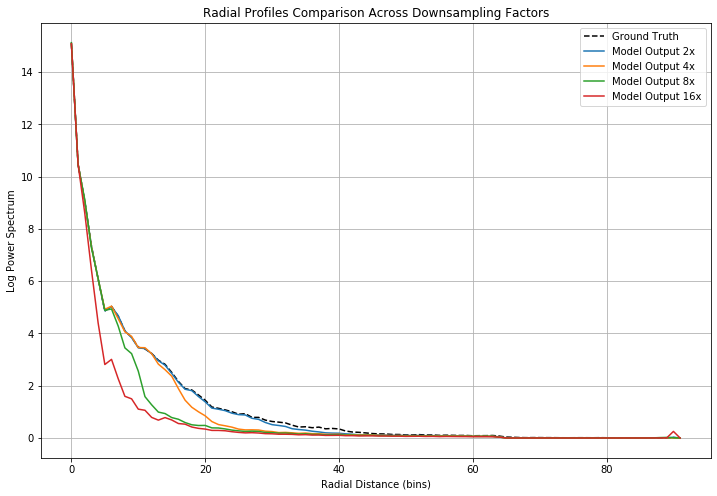

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_radial_profile(file_path):
    """Load the radial profile from a text file."""
    return np.loadtxt(file_path)

def plot_radial_profiles_from_folders(folder_paths, downsampling_factors, ground_truth_folder, output_path):
    """
    Plot radial profiles for different downsampling factors and a common ground truth.
    
    Parameters:
    - folder_paths: List of directories containing radial profile text files for different downsampling factors.
    - downsampling_factors: List of downsampling factors corresponding to each folder.
    - ground_truth_folder: Directory containing the radial profile text file for the ground truth.
    - output_path: Path where the plot will be saved.
    """
    plt.figure(figsize=(12, 8))
    
    # Load the ground truth radial profile
    gt_profile_path = os.path.join(ground_truth_folder, 'radial_profile_gt_2.txt')
    if os.path.exists(gt_profile_path):
        radial_profile_gt = load_radial_profile(gt_profile_path)
        plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, label='Ground Truth', linestyle='--', color='black')
    else:
        raise FileNotFoundError(f"Ground truth file not found: {gt_profile_path}")

    # Load and plot radial profiles for model outputs
    for folder_path, factor in zip(folder_paths, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_2.txt')
        if os.path.exists(model_profile_path):
            radial_profile_model = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_model)), radial_profile_model, label=f'Model Output {factor}x')

    # Set plot labels and title
    plt.xlabel('Radial Distance (bins)')
    plt.ylabel('Log Power Spectrum')
    plt.title('Radial Profiles Comparison Across Downsampling Factors')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

folder_paths = [
    'radial_power_spectra/srflow/2x/',
    'radial_power_spectra/srflow/4x/',
    'radial_power_spectra/srflow/8x/',
    'radial_power_spectra/srflow/16x/'
]

downsampling_factors = ['2', '4', '8', '16']
ground_truth_folder = 'radial_power_spectra/srflow/2x/'
output_path = 'radial_power_spectra/radial_profiles_comparison.png'

plot_radial_profiles_from_folders(folder_paths, downsampling_factors, ground_truth_folder, output_path)


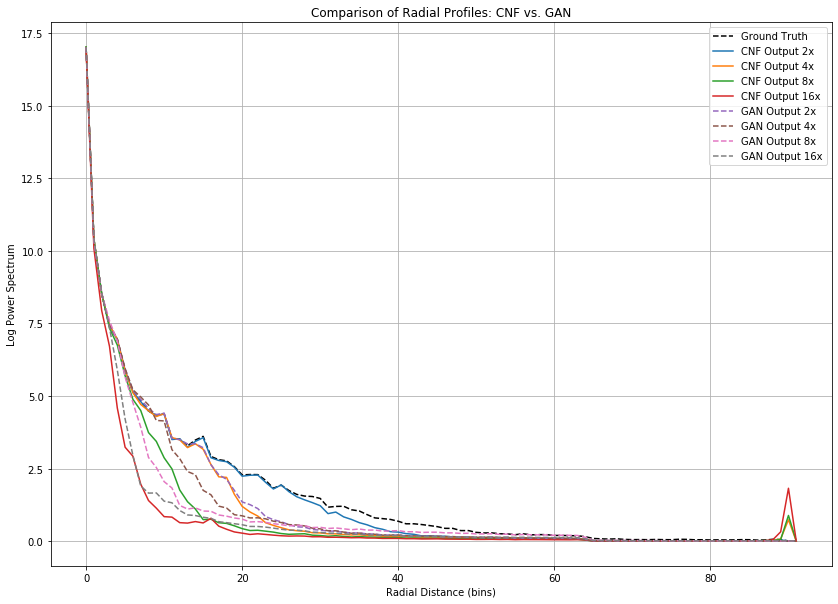

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_radial_profile(file_path):
    """Load the radial profile from a text file."""
    return np.loadtxt(file_path)

def plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path):
    """
    Plot and compare radial profiles for CNF and GAN models across different downsampling factors.
    
    Parameters:
    - cnf_folders: List of directories containing radial profile text files for CNF models.
    - gan_folders: List of directories containing radial profile text files for GAN models.
    - downsampling_factors: List of downsampling factors corresponding to each folder.
    - ground_truth_folder: Directory containing the radial profile text file for the ground truth.
    - output_path: Path where the plot will be saved.
    """
    plt.figure(figsize=(14, 10))
    
    # Load and plot the ground truth radial profile
    gt_profile_path = os.path.join(ground_truth_folder, 'radial_profile_gt_0.txt')
    if os.path.exists(gt_profile_path):
        radial_profile_gt = load_radial_profile(gt_profile_path)
        plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, label='Ground Truth', linestyle='--', color='black')
    else:
        raise FileNotFoundError(f"Ground truth file not found: {gt_profile_path}")

    # Load and plot radial profiles for CNF models
    for folder_path, factor in zip(cnf_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_0.txt')
        if os.path.exists(model_profile_path):
            radial_profile_cnf = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_cnf)), radial_profile_cnf, label=f'CNF Output {factor}x')

    # Load and plot radial profiles for GAN models
    for folder_path, factor in zip(gan_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_0.txt')
        if os.path.exists(model_profile_path):
            radial_profile_gan = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_gan)), radial_profile_gan, label=f'GAN Output {factor}x', linestyle='--')

    # Set plot labels and title
    plt.xlabel('Radial Distance (bins)')
    plt.ylabel('Log Power Spectrum')
    plt.title('Comparison of Radial Profiles: CNF vs. GAN')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()


folder_paths = [
    'radial_power_spectra/srflow/2x/',
    'radial_power_spectra/srflow/4x/',
    'radial_power_spectra/srflow/8x/',
    'radial_power_spectra/srflow/16x/'
]

cnf_folders = [
    'radial_power_spectra/srflow/2x/',
    'radial_power_spectra/srflow/4x/',
    'radial_power_spectra/srflow/8x/',
    'radial_power_spectra/srflow/16x/'
]

gan_folders = [
    'radial_power_spectra/srgan/2x/',
    'radial_power_spectra/srgan/4x/',
    'radial_power_spectra/srgan/8x/',
    'radial_power_spectra/srgan/16x/'
]

downsampling_factors = ['2', '4', '8', '16']
ground_truth_folder = 'radial_power_spectra/srflow/2x/'
output_path = 'radial_power_spectra/radial_profiles_comparison.png'

plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path)

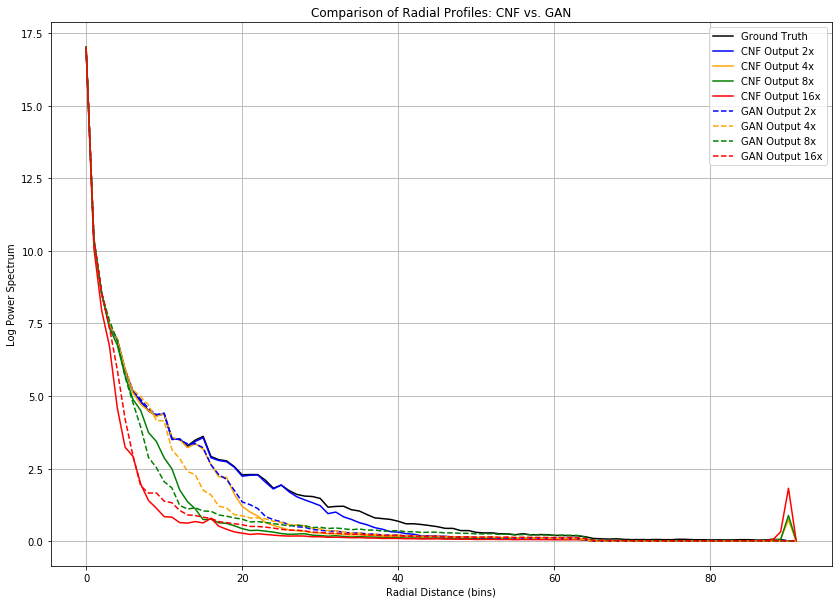

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_radial_profile(file_path):
    """Load the radial profile from a text file."""
    return np.loadtxt(file_path)

def plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path):
    """
    Plot and compare radial profiles for CNF and GAN models across different downsampling factors.
    
    Parameters:
    - cnf_folders: List of directories containing radial profile text files for CNF models.
    - gan_folders: List of directories containing radial profile text files for GAN models.
    - downsampling_factors: List of downsampling factors corresponding to each folder.
    - ground_truth_folder: Directory containing the radial profile text file for the ground truth.
    - output_path: Path where the plot will be saved.
    """
    # Define color map for different downsampling factors
    color_map = {
        '2': 'blue',
        '4': 'orange',
        '8': 'green',
        '16': 'red'
    }
    
    plt.figure(figsize=(14, 10))
    
    # Load and plot the ground truth radial profile
    gt_profile_path = os.path.join(ground_truth_folder, 'radial_profile_gt_0.txt')
    if os.path.exists(gt_profile_path):
        radial_profile_gt = load_radial_profile(gt_profile_path)
        plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, label='Ground Truth', color='black')
    else:
        raise FileNotFoundError(f"Ground truth file not found: {gt_profile_path}")

    # Load and plot radial profiles for CNF models
    for folder_path, factor in zip(cnf_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_0.txt')
        if os.path.exists(model_profile_path):
            radial_profile_cnf = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_cnf)), radial_profile_cnf, label=f'CNF Output {factor}x', color=color_map[factor])

    # Load and plot radial profiles for GAN models
    for folder_path, factor in zip(gan_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_0.txt')
        if os.path.exists(model_profile_path):
            radial_profile_gan = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_gan)), radial_profile_gan, label=f'GAN Output {factor}x', linestyle='--', color=color_map[factor])

    # Set plot labels and title
    plt.xlabel('Radial Distance (bins)')
    plt.ylabel('Log Power Spectrum')
    plt.title('Comparison of Radial Profiles: CNF vs. GAN')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

# Define folder paths and parameters
cnf_folders = [
    'radial_power_spectra/srflow/2x/',
    'radial_power_spectra/srflow/4x/',
    'radial_power_spectra/srflow/8x/',
    'radial_power_spectra/srflow/16x/'
]

gan_folders = [
    'radial_power_spectra/srgan/2x/',
    'radial_power_spectra/srgan/4x/',
    'radial_power_spectra/srgan/8x/',
    'radial_power_spectra/srgan/16x/'
]

downsampling_factors = ['2', '4', '8', '16']
ground_truth_folder = 'radial_power_spectra/srflow/2x/'
output_path = 'radial_power_spectra/radial_profiles_comparison.png'

plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path)
